In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers # type: ignore
import matplotlib.pyplot as plt

Data Loading


In [2]:
#1->Each batch contains 32 images
#2->image(heigth,width)=(256x256)
#3->inage_info(height,width,r,g,b)
#4->number of times each batch is iterated

In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=25

In [6]:
# here all the 3 datasets are combined into one and the images are resized to 256x256
# the dataset is shuffled and the batch size is set to 32

# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "PlantVillage",
#     shuffle=True,
#     image_size=(IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE 
    )

Found 2152 files belonging to 3 classes.


In [7]:
# displays labes as class names of the images
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Data Visualization
image

In [9]:
#image_batch(batch_size,height,weight,rgb)
#labels_batch('Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy') as (0,1,2) in numpy array

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


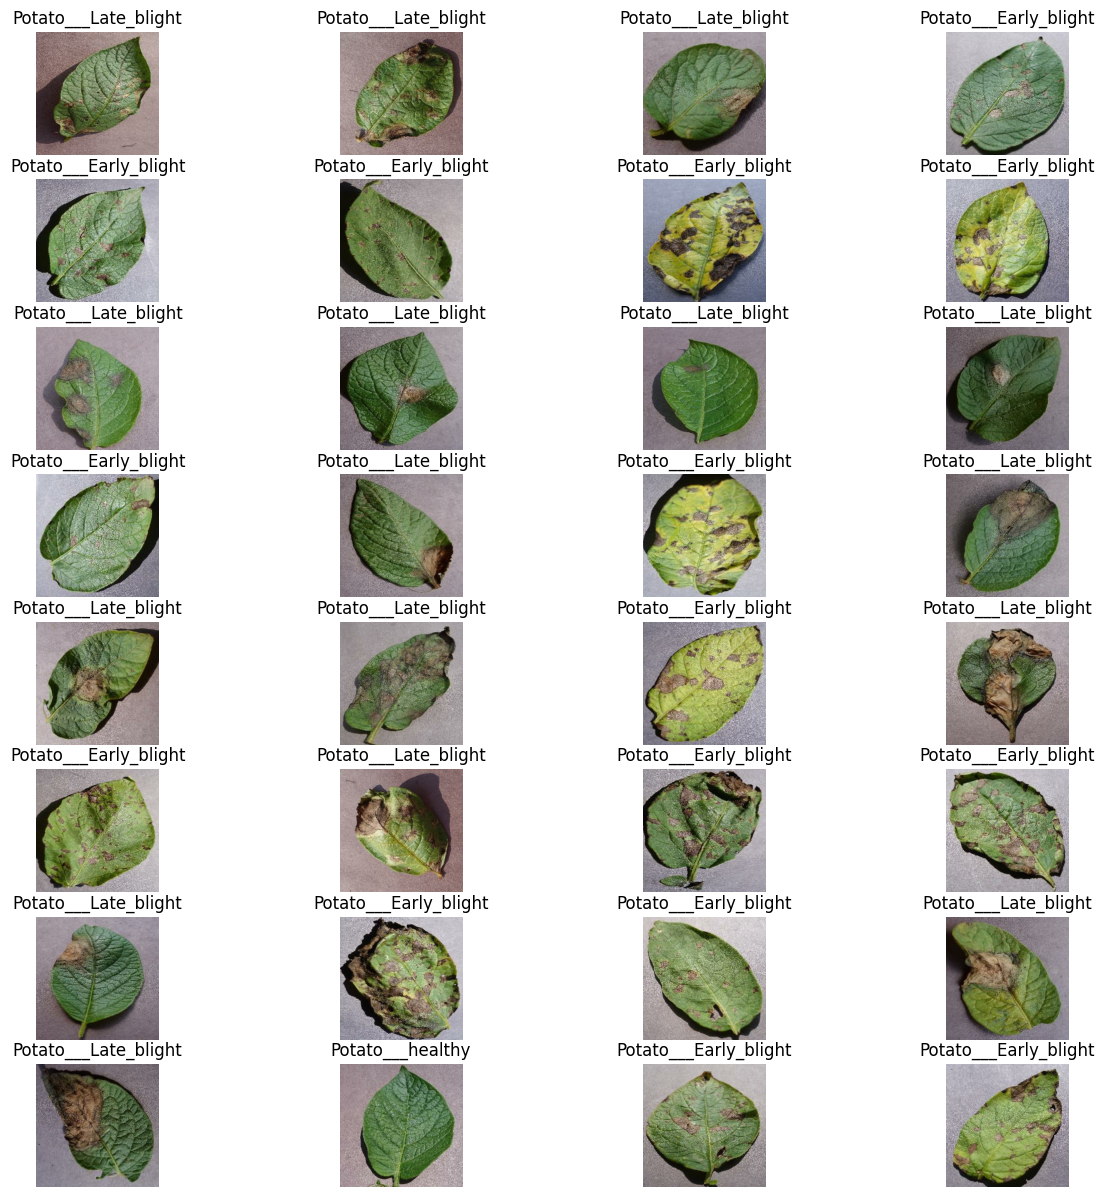

In [10]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(32):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[labels_batch[i]])

train dataset -> 80%(approx 54)
validation dataset -> 10%(approx 6)
test dataset -> 10%(approx 8)

In [11]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(int(len(dataset)*train_size))
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(int(len(train_ds)))
len(test_ds)

14

In [14]:
vali_size=0.1
len(dataset)*vali_size

6.800000000000001

In [15]:
vali_ds=test_ds.take(int(len(dataset)*vali_size))
len(vali_ds)

6

In [16]:
test_ds=test_ds.skip(int(len(vali_ds)))
len(test_ds)

8

In [17]:
def get_partioned_dataset(ds, train_split=0.8, vali_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    assert (train_split + vali_split + test_split) == 1

    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size=int(ds_size* train_split)
    vali_size=int(ds_size* vali_split)
    test_size=int(ds_size* test_split)

    return train_ds, vali_ds, test_ds

In [18]:
train_ds, vali_ds, test_ds = get_partioned_dataset(dataset)
print(len(train_ds))
print(len(vali_ds))
print(len(test_ds))

54
6
8


Optimizing the input pipeline


In [19]:
#cache()->store the dataset in memory after 1st epoche, speed up the training process
#shuffle->randomize the dataset
#refetch->load the next batch of data beforehand

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
vali_ds = vali_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  #resize the images to (256X256)
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  #rescale the pixel values to [0,1] dividing by 255
  layers.Rescaling(1.0/255),
])

Data Augmentaion

In [22]:
#here we are using data augmentation to increase the size of the training dataset
# this helps to prevent overfitting and improve the model's performance

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras import layers # type: ignore

data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal and_vertical"),
    layers.RandomRotation(0.2)
]) 

Model Building

In [23]:
input_image = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=input_image),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=input_image)

d:\USER\OneDrive\Desktop\Final_yr\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history =model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=vali_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 921ms/step - accuracy: 0.4884 - loss: 0.9173 - val_accuracy: 0.4844 - val_loss: 0.8118
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.6979 - loss: 0.6339 - val_accuracy: 0.8854 - val_loss: 0.2739
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 869ms/step - accuracy: 0.8866 - loss: 0.2891 - val_accuracy: 0.9479 - val_loss: 0.1519
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 754ms/step - accuracy: 0.8843 - loss: 0.2761 - val_accuracy: 0.9375 - val_loss: 0.1898
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 744ms/step - accuracy: 0.9311 - loss: 0.1831 - val_accuracy: 0.9479 - val_loss: 0.1020
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 751ms/step - accuracy: 0.9230 - loss: 0.1852 - val_accuracy: 0.9531 - val_loss: 0.1254
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 749ms/step - accuracy: 0.9369 - loss: 0.1630 - val_accuracy: 0.8906 - val_loss: 0.2467
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 742ms/step - accuracy: 0.9520 - loss: 0.1376 - val_accu

In [27]:
score = model.evaluate(test_ds)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9914 - loss: 0.0278


[0.027801183983683586, 0.9913793206214905]

In [28]:
history.history['accuracy']

[0.48842594027519226,
 0.6979166865348816,
 0.8865740895271301,
 0.8842592835426331,
 0.9311342835426331,
 0.9230324029922485,
 0.9369212985038757,
 0.9519675970077515,
 0.9606481194496155,
 0.9421296119689941,
 0.9484953880310059,
 0.9612268805503845,
 0.9704861044883728,
 0.96875,
 0.9646990895271301,
 0.9646990895271301,
 0.9704861044883728,
 0.9762731194496155,
 0.9751157164573669,
 0.9866898059844971,
 0.9814814925193787,
 0.9704861044883728,
 0.9745370149612427,
 0.9872685074806213,
 0.9861111044883728]

In [29]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy'] 
loss=history.history['loss']
val_loss=history.history['val_loss']

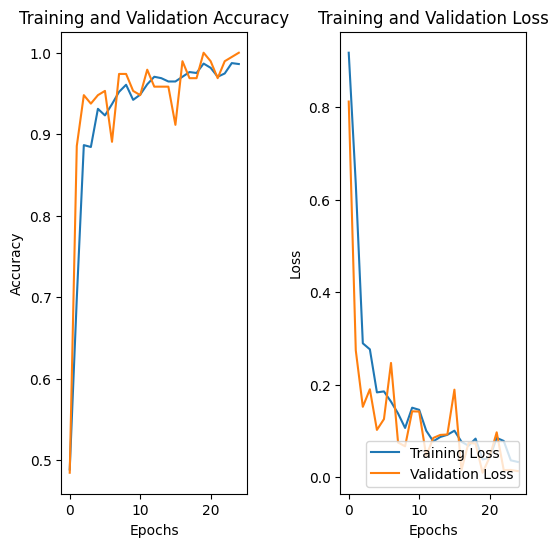

In [30]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Save Model

In [ ]:
model_version = 1

In [ ]:

# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1

In [39]:
model.export(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


Saved artifact at '../models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2780660923664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780660924048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807301840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807302608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807300880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807301264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807303760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807302992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807304144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807303952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2780807301456: TensorSpec(shape=(), dty

In [40]:
model.save(f"../models/V{model_version}.keras")


In [34]:
model.save(f"../models/model_v{model_version}.h5")